# Machine Learning
 
**Autori:** Erik Matovič a Simon Kokavec   
**Číslo datasetu:** 165  
**Percentuálny podiel:** 50/50

## 0. Importovanie

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as py
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import math
from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

### Zadanie  
   - Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
   
   - Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátora pomocou metrík accuracy, precision a recall.

### Riešenie  

#### Načítanie datasetov



In [2]:
df_train = pd.read_csv('../../data/train.csv', sep=',')
df_test = pd.read_csv('../../data/test.csv', sep=',')
df_train.head()

,hemoglobin,leukocyty,etytr,weight,trombocyty,ast,alp,relationship,alt,hbver,smoker,erytrocyty,er-cv,indicator,hematokrit,sex,blood_group,age,race
0,0.240147,1.215254,-0.386530,-1.324705,1.012197,-0.085403,0.979523,1.0,-1.189322,-0.749305,1.0,-0.866056,-0.007817,1.0,-0.400413,0.0,2.0,-1.036721,4.0
1,-0.775564,-0.651757,-1.060210,-1.772392,-0.354930,0.556809,1.128525,1.0,-0.534179,1.053322,0.0,-0.461494,-0.660851,0.0,-0.982859,0.0,1.0,-0.347098,1.0
2,0.225980,0.146206,-1.423915,2.480386,2.024872,-1.036218,0.509456,3.0,-0.748730,0.590570,0.0,0.088501,-0.318734,0.0,2.696982,1.0,8.0,1.679314,1.0
3,-1.761756,-1.509458,0.289679,1.369844,0.516427,-0.677995,-1.674788,1.0,-0.993768,-0.292905,0.0,-0.324790,-2.056547,0.0,-0.025407,0.0,3.0,-1.166164,1.0
4,0.298584,-0.571938,0.519505,0.914422,-0.972209,2.060500,0.990801,3.0,-0.893681,0.048618,0.0,-0.484866,0.030176,0.0,-0.822366,0.0,3.0,1.161745,2.0


### Upravenie testovacieho datasetu na základe druhej fázy projektu  
 - `preprocessing.py` obsahuje transformery z druhej fázy projektu, potreba aplikovať na testovací dataset

In [3]:
import preprocessing

pipeline_obj2 = Pipeline([
        ('Transformer_scal', preprocessing.ScalingTransform(df_test, 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv','alt', 'hematokrit','age', 'erytrocyty')),
        ('Transformer_yeo', preprocessing.PowerTransform(df_test, 'yeo-johnson', 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv', 'alt','hematokrit','age', 'erytrocyty'))

])

test_final = pipeline_obj2.transform(df_test) 

 - v prieskumnej analýze údajov sme identifikovali vzťahy medzi `indicator`, s ktorými pracujeme v tejto fáze projektu, distribučný graf leukocytov a etytrov:

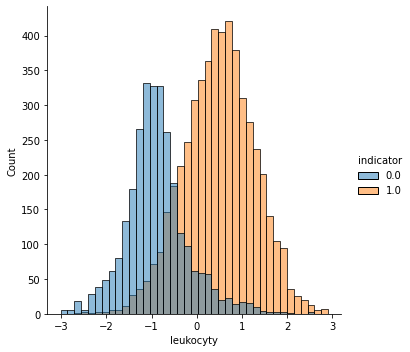

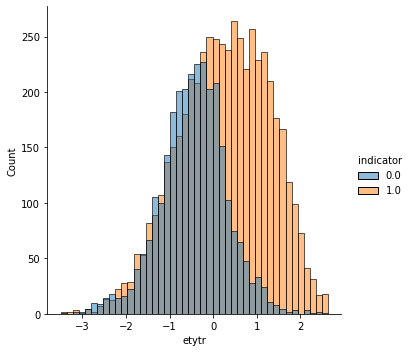

In [4]:
print(sns.displot(x = "leukocyty", hue = "indicator", data = df_train))
print(sns.displot(x = "etytr", hue = "indicator", data = df_train))

 - histogram a distribučný graf leukocytov a etytr chorych a zdravych pacientov:

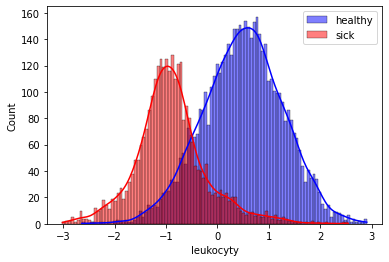

In [5]:
healthy_sample = df_train.loc[df_train.indicator == 1]
sick_sample = df_train.loc[df_train.indicator == 0]

sns.histplot(healthy_sample.leukocyty, bins=100, color='blue', kde=True, label='healthy')
sns.histplot(sick_sample.leukocyty, bins=100, color='red', kde=True, label='sick')
plt.legend()

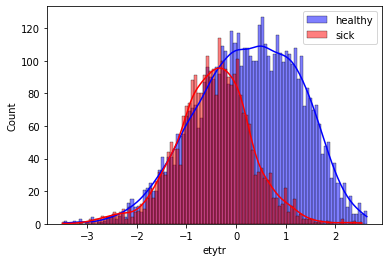

In [6]:
sns.histplot(healthy_sample.etytr, bins=100, color='blue', kde=True, label='healthy')
sns.histplot(sick_sample.etytr, bins=100, color='red', kde=True, label='sick')
plt.legend()

 - nájdeme rovnaké hodnoty etytr pre chorých a zdravých pacientov:

In [7]:
set(healthy_sample.etytr) & set(sick_sample.etytr)

{-1.1887828598149432,
 -1.0584568701074972,
 -0.95571169173116,
 -0.94698321457296,
 -0.2760184271031619,
 -0.1852133816528613,
 -0.1796479982960091,
 -0.084743904304865,
 -0.0230636675829741,
 -0.0053921223533662,
 0.0381514294825971,
 0.0530534896348707,
 0.1212574594375991,
 0.2422042115420119,
 0.3990869696657575,
 0.4844555472338493,
 0.6293536726809048}

 - nájdeme rovnaké hodnoty leukocyty pre chorých a zdravých pacientov:

In [8]:
set(healthy_sample.leukocyty) & set(sick_sample.leukocyty)

{-0.5971182626986881,
 -0.5161366108060701,
 -0.3686892126470269,
 -0.1718740656189382,
 -0.0249250306746316,
 0.0741790689681667,
 0.5949291015640512,
 0.6064474433099962}

### 1 Rule Algoritmus
 - na základe prienikov hodnot leukocytov sme vytvorili 1R algoritmus pre leukocyty ako náš prvý prototyp, pričom pracujeme s celkovou populaciou(total), total positive, total negative, false positive, false negative, pričom leukocyt bol vybratý ako vhodný atribút ešte z prvej fázy, z prieskumnej analýzy údajov, a hodnota -0.36 bola vybratá z hodnôt prienikov zdravých a chorých pacientov:

In [9]:
def oner_1rule(data):
    rules = dict()
    rules["total"] = data['indicator'].count()
    rules["tp"] = len(data.loc[(data.leukocyty >= -0.36) & (data['indicator'] == 1.0), 'indicator'])
    rules["tn"] = len(data.loc[(data.leukocyty < -0.36) & (data['indicator'] == 0.0), 'indicator'])
    rules["fp"] = len(data.loc[(data.leukocyty >= -0.36) & (data['indicator'] == 0.0), 'indicator'])
    rules["fn"] = len(data.loc[(data.leukocyty < -0.36) & (data['indicator'] == 1.0), 'indicator'])
    return rules
    

 - vypočet:
    - accuracy: (TP + TN) / total population
    - precision: TP / (FP + TP)
    - recall: TP / (FN + TP) 
- funkcia na výpis accuracy, precision a recall, ktore sme pocitali podla vyššie uvedených vzorcov 

In [10]:
def printer(rules):
    print("Accuracy: ",(rules["tp"] + rules["tn"]) / rules["total"])
    print("Precision: ", rules["tp"] / (rules["fp"] + rules["tp"]))
    print("Recall: ", rules["tp"] / (rules["fn"] + rules["tp"]))

 - výsledky 1R algorimu ukazuju na trénovacích dátach vyše 85% úspešnosť:

In [11]:
result = oner_1rule(df_train)
printer(result)

Accuracy:  0.8511459890383657
Precision:  0.9037487335359676
Recall:  0.861003861003861


 - výsledky 1R algorimu ukazuju na testovacích dátach porovnateľnú úspešnosť:

In [12]:
result = oner_1rule(test_final)
printer(result)

Accuracy:  0.8460388639760837
Precision:  0.8904448105436573
Recall:  0.8599840891010342


 - vizualizácia trénovacích dát:

<AxesSubplot:xlabel='etytr', ylabel='leukocyty'>

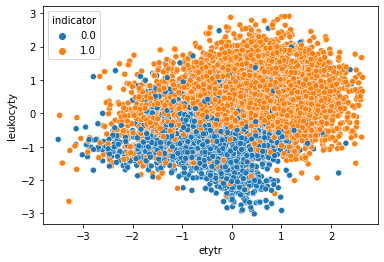

In [13]:
sns.scatterplot(y="leukocyty", x="etytr", hue="indicator", data=df_train)

 - následne sme implementovali 1R algoritmus pre výber najlepšieho parametru, inšpirovali sme sa nasledovným [zdrojom](https://github.com/mfreyeso/oner-scratch?fbclid=IwAR3CTjCs16HZqshZQCj5K9Ba-8dHGtYkj4Mu6UDLGGxnacyvkNNr_cP0yec)

In [14]:
class OneR(object):
    """
    1R implementation
    """
    
    def __init__(self):
        """
        Constructor
        """
        self.ideal_variable = None
        self.max_accuracy = 0
    
    def fit(self, dfx, y):
        """
        Find best parameter
        
        :param dfx: dataset
        :param y: target
        """
        response = list()
        result = dict()
        
        for i in dfx:
            """
            i is a column in the dataset
            """
            result[str(i)] = dict() 
            options_values = set(dfx[i])
            join_data = pd.DataFrame({"variable":dfx[i], "label":y})
            cross_table = pd.crosstab(join_data.variable, join_data.label)
            summary = cross_table.idxmax(axis=1)
            result[str(i)] = dict(summary)
            
            counts = 0
            
            for idx, row in join_data.iterrows():
                if row['label'] == result[str(i)][row['variable']]:
                    counts += 1

            accuracy = (counts/len(y))
            print(f"{i}, {accuracy}\n")
            
            if accuracy > self.max_accuracy:
                self.max_accuracy = accuracy
                self.ideal_variable = i

            result_feature = {"variable": str(i), "accuracy":accuracy, "rules": result[str(i)] }  
            response.append(result_feature)
            
        return response

    
    def predict(self, X=None):
        self_ideal_variable = self.ideal_variable + 1
        
    def __repr__(self):
        if self.ideal_variable != None:
            txt = "Najlepšia premenná pre vaše údaje je: " + str(self.ideal_variable)
        else:
            txt = "Najlepšia premenná ešte nebola nájdená"
        return txt


 - avšak ako ukazujú výstupy, tak takmer vśetky atribúty vyhodnotil s accuracy 99% a ako najlepší atribút je váha(weight), čo nekorešponduje s našími poznatkami z prieskumnej analýzy

In [15]:
#prepared_dataset = df_train.drop(['indicator'],axis='columns')
prepared_dataset = df_train.drop(['indicator'],axis='columns')

clf_custom = OneR()
clf_custom.fit(prepared_dataset, df_train['indicator'])

print(clf_custom)

hemoglobin, 0.9942700548081714

leukocyty, 0.9990034877927254

etytr, 0.9978824115595416

weight, 0.9991280518186347

trombocyty, 0.992526158445441

ast, 0.997633283507723

alp, 0.9936472346786248

relationship, 0.645241654210264

alt, 0.9885401096163428

hbver, 0.9973841554559043

smoker, 0.645241654210264

erytrocyty, 0.9966367713004485

er-cv, 0.9977578475336323

hematokrit, 0.992526158445441

sex, 0.645241654210264

blood_group, 0.645241654210264

age, 0.645241654210264

race, 0.645241654210264

Najlepšia premenná pre vaše údaje je: weight


 - najlepší atribút ukazuje `leukocyty` ale až po vyhodení atribútu váhy(weight), `leukocyty` sa viažu lepšie s `indicator`, v prieskumnej analýze údajov sme podrobili analýze aj z medicínskeho hľadiska naše dáta a už v prvej fáze projektu sme identifikovali tento atribút ako najlepší na fázu strojového učenia

In [16]:
prepared_dataset = df_train.drop(['indicator'],axis='columns')
prepared_dataset = prepared_dataset.drop(['weight'],axis='columns')

clf_custom = OneR()
clf_custom.fit(prepared_dataset, df_train['indicator'])

print(clf_custom)

hemoglobin, 0.9942700548081714

leukocyty, 0.9990034877927254

etytr, 0.9978824115595416

trombocyty, 0.992526158445441

ast, 0.997633283507723

alp, 0.9936472346786248

relationship, 0.645241654210264

alt, 0.9885401096163428

hbver, 0.9973841554559043

smoker, 0.645241654210264

erytrocyty, 0.9966367713004485

er-cv, 0.9977578475336323

hematokrit, 0.992526158445441

sex, 0.645241654210264

blood_group, 0.645241654210264

age, 0.645241654210264

race, 0.645241654210264

Najlepšia premenná pre vaše údaje je: leukocyty


 - z vyššie uvedených dôvodov sme sa rozhodli implementovať najlepšie vlastný 1R algoritmus pre výber najlepšieho atribútu na základe indicator, pričom vychádzame z nášho pôvodnému algoritmu vyššie, ktorý sme testovali na leukocytoch:

In [17]:
class OneRBestAtribute(object):
    """
    1R implementation
    """
    
    def __init__(self):
        """
        Constructor
        """
        self.d_accuracy = dict()
        self.d_precision = dict()
        self.d_recall = dict()
        self.max_key = 0
    
    def fit(self, data):
        """
        Find best parameter
        
        :param data: dataset
        :param target: target
        """
        healthy_sample = data.loc[data.indicator == 1]
        sick_sample = data.loc[data.indicator == 0]

        # najdeme prieniky medzi zdravymi a chorymi pacientmi
        d_values = dict()
        for i in data:        
            d_values[str(i)] = list(
                set(healthy_sample[str(i)]) & set(sick_sample[str(i)])
            )
            
        target = data['indicator']

        # ziskame najlepssi accuracy pre kazdy atribut
        for index, (k, v) in enumerate(d_values.items()):
            #print(k)
            if (str(k) == "indicator"):
                continue
            list_accuracy = list()
            list_precision = list()
            list_recall = list()
            for i in v:
                rules = dict()
                rules["total"] = target.count()
                rules["tp"] = len(data.loc[(data[str(k)] >= round(i, 3)) & (target == 1.0), 'indicator'])
                rules["tn"] = len(data.loc[(data[str(k)] < round(i, 3)) & (target == 0.0), 'indicator'])
                rules["fp"] = len(data.loc[(data[str(k)] >= round(i, 3)) & (target == 0.0), 'indicator'])
                rules["fn"] = len(data.loc[(data[str(k)] < round(i, 3)) & (target == 1.0), 'indicator'])
                list_accuracy.append((rules["tp"] + rules["tn"]) / rules["total"])
                list_precision.append(rules["tp"] / (rules["fp"] + rules["tp"]))
                list_recall.append(rules["tp"] / (rules["fn"] + rules["tp"]))
            max_accurancy = max(list_accuracy)
            max_index = list_accuracy.index(max_accurancy) # najdi index
            self.d_accuracy[str(k)] =  list_accuracy[max_index] # save max number
            self.d_precision[str(k)] = list_precision[max_index]
            self.d_recall[str(k)] = list_recall[max_index] 
            self.max_key = max(self.d_accuracy, key=self.d_accuracy.get)

            
    def __repr__(self):
        """
        Returns representation when printing an object
        """
        txt = "Najlepší atribút pre údaje je: " + self.max_key;
        txt += "\n\ts Accuracy: " + str(self.d_accuracy[self.max_key])
        txt += "\n\ts Precision: " + str(self.d_precision[self.max_key])
        txt += "\n\ts Recall: " + str(self.d_recall[self.max_key])
        return txt

 - Ziskame najlepsi atribut z nasej implementovanej triedy:

In [18]:
oneRObject = OneRBestAtribute()
oneRObject.fit(df_train)

print(oneRObject)

Najlepší atribút pre údaje je: leukocyty
	s Accuracy: 0.8557548579970105
	s Precision: 0.881883782757311
	s Recall: 0.8965250965250965


 - algoritmus vyhodnotil najlepší atribút ako leukocyty, vizualizácia ukazuje prirodzené rozdelenie niekde medzi hodnotami -1 a 0

<AxesSubplot:xlabel='leukocyty', ylabel='leukocyty'>

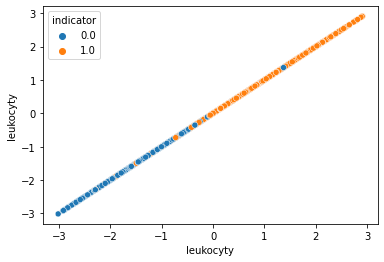

In [19]:
sns.scatterplot(y="leukocyty", x="leukocyty", hue="indicator", data=df_train)

 - po vyhodení atribútu `leukocyty` vieme z prieskumnej analýzy údajov, že druhým najlepším atribútom je `etytr`, a teda ten očakávame v našom 1R algoritme pre výber najlepšieho atribútu v kombinácií s `indicator`, a aj sme dostali očakávaný výsledok:

In [20]:
df_no_leukocyty = df_train.drop(['leukocyty'],axis='columns')
oneRObject_no_leukocyty = OneRBestAtribute()
oneRObject_no_leukocyty.fit(df_no_leukocyty)

print(oneRObject_no_leukocyty)

Najlepší atribút pre údaje je: etytr
	s Accuracy: 0.6550822122571002
	s Precision: 0.7707163709858522
	s Recall: 0.6625482625482626


 - algoritmus vyhodnotil najlepší atribút ako `etytr` po vyhodení atribútu `leukocyty`, vizualizácia ukazuje nie až tak prirodzené rozdelenie, preto je aj presnosť `etytr` nižšia o približne 20% oproti atribútu `leukocyty`, ktorý sa lepšie viaže s určovaním chorých a zdravých pacientov podľa `indicator` atribútu

<AxesSubplot:xlabel='etytr', ylabel='etytr'>

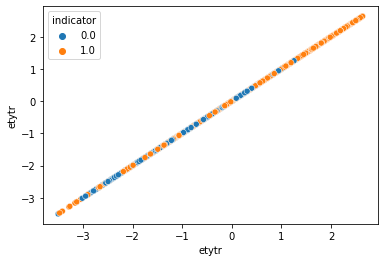

In [21]:
sns.scatterplot(y="etytr", x="etytr", hue="indicator", data=df_train)

## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia

### Zadanie  
   - Na trénovanie využite minimálne jeden stromový algoritm strojového učenia v scikit-learn.
   - Vizualizujte natrénované pravidlá.
   - Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
   - Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.

### Riešenie 

#### DecisionTreeClassifie 

 - použijeme **DecisionTreeClassifie** s rôznymi __criterion__  
 
##### Gini
 - implementácia DecisionTreeClassifier s Gini stromu aj s  overením:

In [22]:
df_prepared = df_train.drop(columns=["indicator"])
df_testing = df_test.drop(columns=["indicator"])

model = tree.DecisionTreeClassifier(criterion="gini", max_depth=5)
model = model.fit(df_prepared, df_train["indicator"])

data_tree = model.predict(df_testing)

print("Accuracy: ",accuracy_score(data_tree, df_test["indicator"]))
print("Precission: ", precision_score(data_tree, df_test["indicator"]))
print("Recall: ", recall_score(data_tree, df_test["indicator"]))


Accuracy:  0.9412057797708022
Precission:  0.9578361177406524
Recall:  0.9487785657998424


Počet:
pravdivo neagtívnych [0,0]
falošne negatívnych [1,0]
pravdivo pozitívnych [1,1]
falošne pozitívnych [0,1]


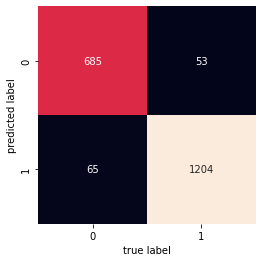

In [23]:
mat = confusion_matrix(df_test["indicator"], data_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

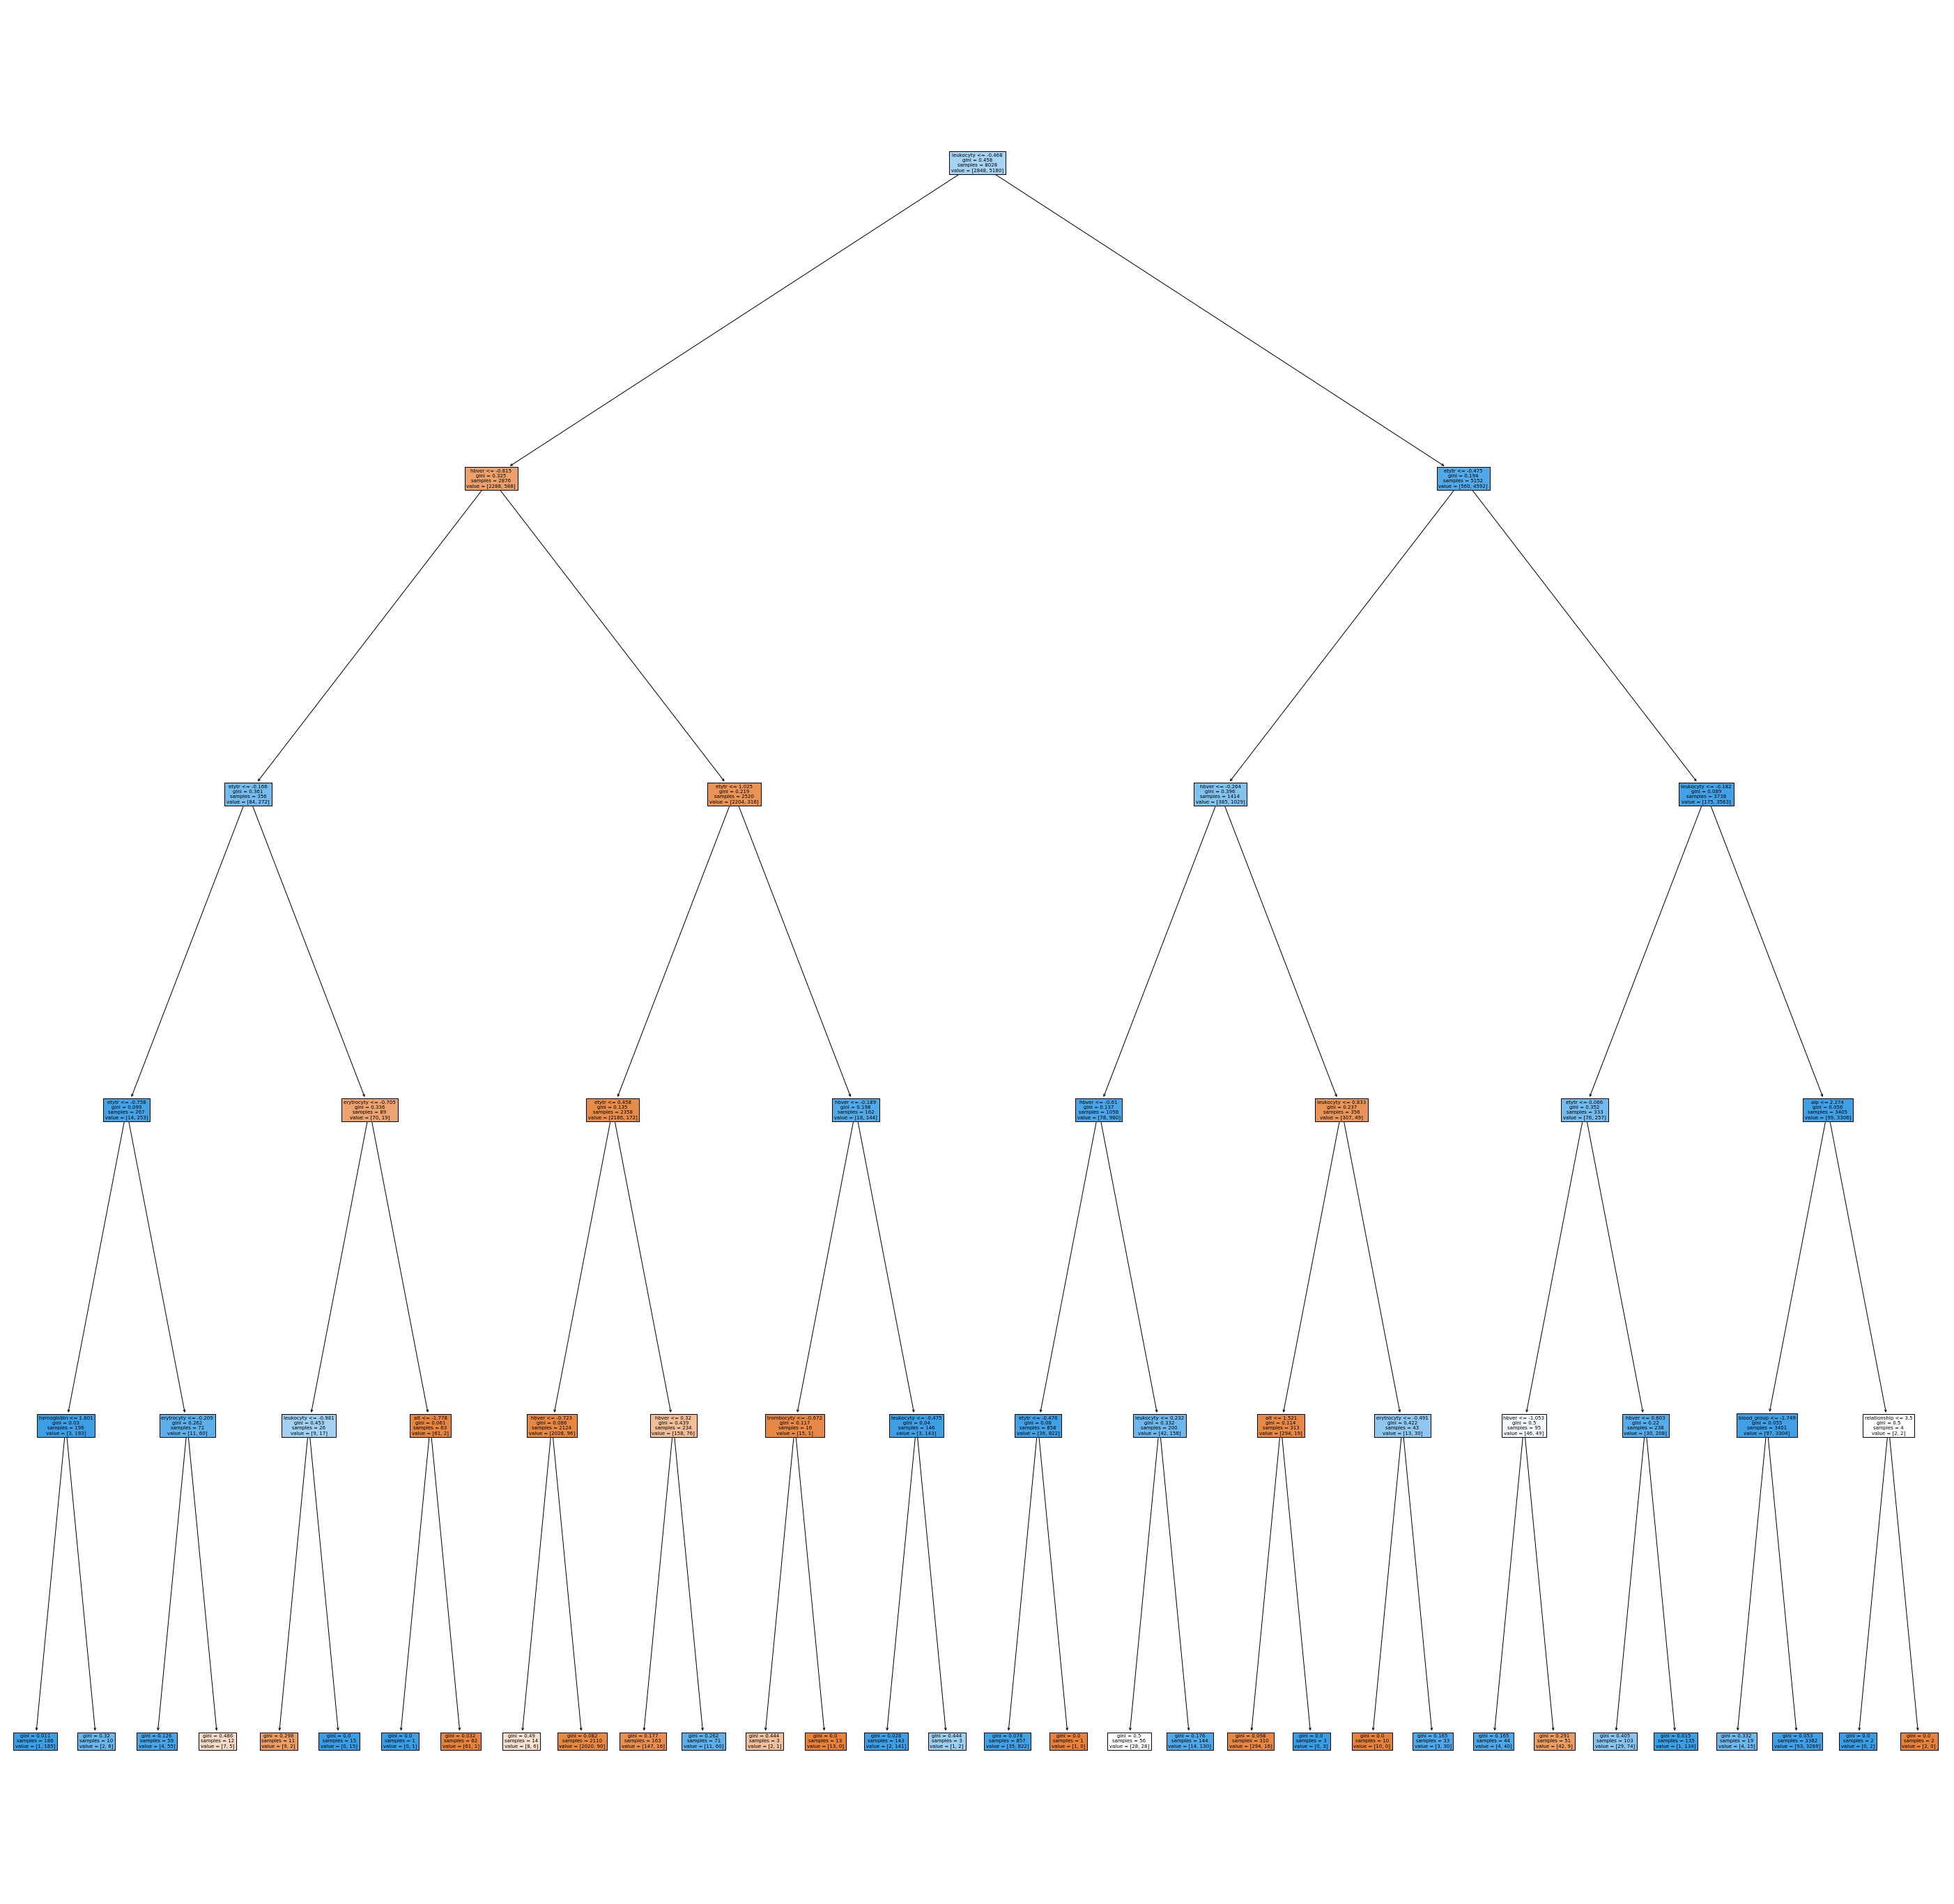

In [24]:
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(model, feature_names=df_test.columns, filled=True)
fig.savefig('strom_gini.png')

##### Entropy
 - implementácia stromu DecisionTreeClassifie s Entropy aj s  overením:

In [25]:
df_prepared = df_train.drop(columns=["indicator"])
df_testing = df_test.drop(columns=["indicator"])

model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model = model.fit(df_prepared, df_train["indicator"])

data_tree = model.predict(df_testing)

print("Accuracy: ",accuracy_score(data_tree, df_test["indicator"]))
print("Precission: ",precision_score(data_tree, df_test["indicator"]))
print("Recall: ",recall_score(data_tree, df_test["indicator"]))

Accuracy:  0.9387144992526159
Precission:  0.9610182975338106
Recall:  0.9422776911076443


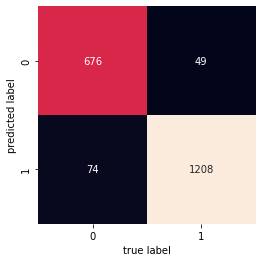

In [26]:
mat = confusion_matrix(df_test["indicator"], data_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

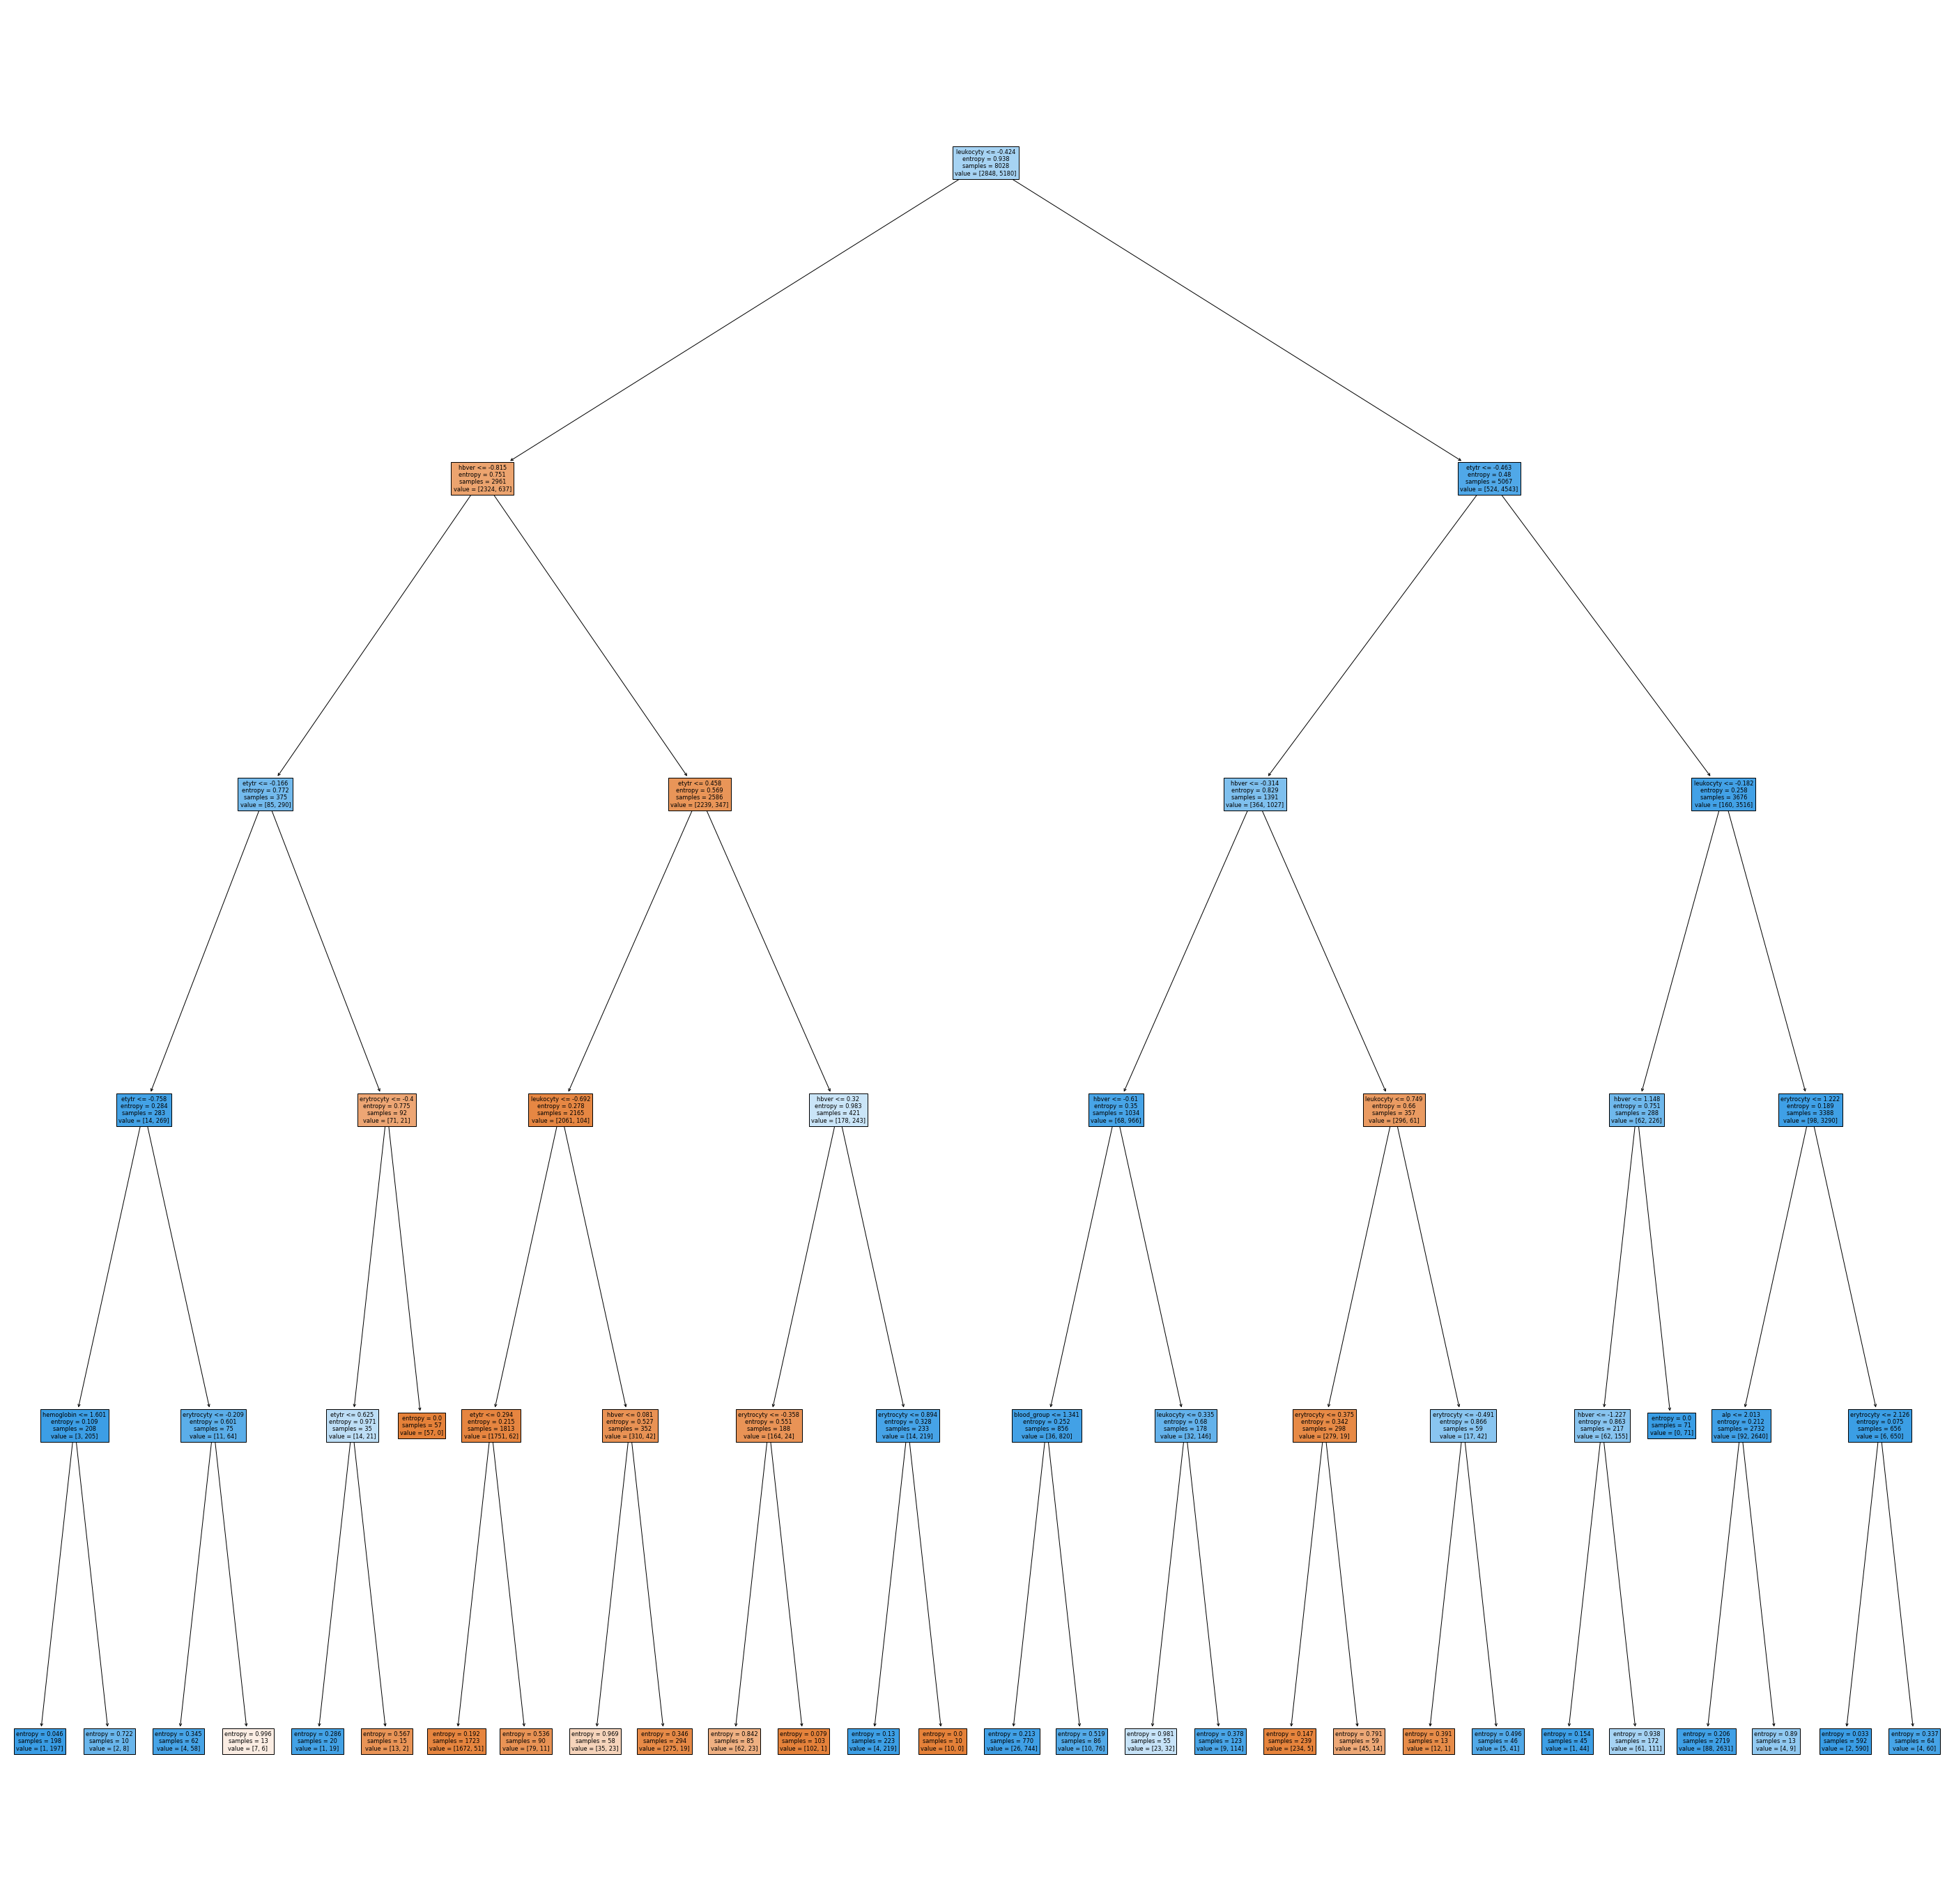

In [27]:
fig=plt.figure(figsize=(50,50))
_ = tree.plot_tree(model, feature_names=df_test.columns, filled=True)
fig.savefig('strom_entropy.png')

#### Porovnanie

Natrénovaný stromový algoritmus z knižnice scikit dosahoval lepšie výsledky ako nami vytvorený algoritmus v úlohe 1. Rozdiel medzi presnosťou sa pohybue vždy okolo 9% a to aj ak využívame criterion entropy alebo gini. Nami vytvorený algoritmus dosahuje presnosť okolo 85% s malými rozdielmi. Algoritmy knižnice scikit sa pohybujú okolo 93-94% z čoho usudzujeme zreteľné zlepšenie. Algoritmus s crierion nastaveným na Gini dosahoval lepšie výsledky oproti entropy (Rozdiel okolo 0.5% v accuracy).

## 3. Optimalizácia - hyperparameter tuning

### Zadanie  
- Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
- Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

### Riešenie  

Hyperparameter tuning vykonáme pre stromový algoritmus **DecisionTreeClassfier** z Python modulu sklearn.

 - vytvoríme najprv rozhodovací strom **DecisionTreeClassfier**: 

In [28]:
decision_tree = tree.DecisionTreeClassifier()

 - vytvoríme si dataset a target pre naše modely:

In [29]:
df_train_no_indicator = df_train.drop(columns=["indicator"])
target = df_train.indicator

V rámci **DecisionTreeClassifier** budeme pouźívať nasledovné parametre:
 - **criterion** - funkcia pre meranie kvality rozdelenia, predvolená hodnota je Gini, ale je možnosť na výber aj Entropy
 - **splitter** - ponúka na výber hodnoty “best” a “random”, pričom predvolená hodnota je ”best”, stratégia výberu rozdelenia pre každý uzol, kde “best” stratégia vyberá najlepšie rozdelenie a “random” je stratégia pre najlepšie náhodné rozdelenie
 - **max_depth** - ako už názov napovedá jedná sa o maximalnu hĺbku stromu, predvolená hodnota je None
 - **min_samples_split** - minimálny počet vzoriek na rozdelenie uzla stromu, predvolená hodnota je 2
 - **min_samples_leaf** - minimálny počet vzoriek, ktoré musia byť v listoch stromu, predvolená hodnota je 1
 - **max_features** - zohľadňuje maximálny počet atribútov hľadaní najlepšieho rozdelenia, predvolená hodnota je None

Fitting 10 folds for each of 37908 candidates, totalling 379080 fits
Best Params:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 9, 'min_samples_leaf': 6, 'min_samples_split': 3, 'splitter': 'best'}
Accuracy:  0.9322371699053313
Precission:  0.9363564041368337
Recall:  0.9545823195458232


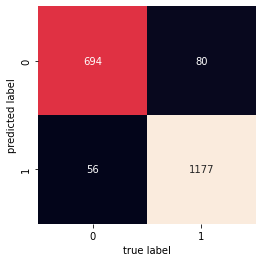

In [30]:
parameters = {
    'criterion': ('gini','entropy'), 
    'splitter': ('best','random'), 
    'max_depth': range(2,15), 
    'max_features': range(1,10),
    'min_samples_split': range(1,10),
    'min_samples_leaf': range(1,10) 
}

# 10-nasobna cross validation
# n_jobs=-1 use all CPU & run in it parallel
optimalizationGridSearch = GridSearchCV(decision_tree, parameters, cv=10, verbose=1, n_jobs=-1)
bestFit = optimalizationGridSearch.fit(df_train_no_indicator, target)

# Prediction on testing dataset
df_test_no_indicator = df_test.drop(['indicator'],axis='columns')
data_tree = bestFit.predict(df_test_no_indicator)

# Best parameters
print("Best Params: ", bestFit.best_params_)

print("Accuracy: ",accuracy_score(data_tree, df_test["indicator"]))
print("Precission: ", precision_score(data_tree, df_test["indicator"]))
print("Recall: ", recall_score(data_tree, df_test["indicator"]))

# Confusion Matrix
mat = confusion_matrix(df_test["indicator"], data_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### Zadanie  
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 
- Stratégie riešenia chýbajúcich hodnôt a outlierov;
- Scaling resp. transformer či zlepší accuracy klasifikácie;
- Výber atribútov a výber algoritmov;
- Hyperparameter tuning resp. ensemble learning.

Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.


### Riešenie  

### Stratégia riešenia chýbajúcich hodnôt a outlierov

- pre vyhodnotenie všetkých bodov zo zadania sme doplnili súbor `preprocessing.py` našim algoritmom One Rule. Taktiež sme do neho preniesli všetky potrebné transformácie z Fázy 2 aby vyhodnotenie prebehlo jednoduchšie. 
- Začneme načítaním základných nespracovaných datasetov

In [31]:
df_labor_ = pd.read_csv('../../data/labor.csv', sep='\t')
df_profiles_ = pd.read_csv('../../data/profiles.csv', sep='\t')

- Vytvorili sme pipeline ako z fázy 2 spolu s One Rule algoritmom a Hypertuningom. Pomocou tejto pipeline budeme vyhodnocovať vplyv zvolenej stratégie.

In [ ]:
df_merged2 = pd.DataFrame()

pipeline_obj = Pipeline([
        ('merge', preprocessing.MergeTransformer(df_labor_, df_profiles_, column1 ='ssn', column2 ='name')),
        ('dropCols', preprocessing.DropColsTransformer(df_merged2, 'Unnamed: 0_x', 'name', 'ssn', 'Unnamed: 0_y','current_location', 'residence', 'address')),
        ('numSex', preprocessing.GetNumericalTransformer(df_merged2, 'sex', {"M": 0, "F": 1}, 'float64')),
        ('numBlood', preprocessing.GetNumericalTransformer(df_merged2, 'blood_group', {"A+": 1,"A-": 2, "B+": 3, "B-": 4, "AB+": 5, "AB-": 6, "O+": 7, "O-": 8}, 'float64')),
        ('numRepairRace', preprocessing.GetNumericalTransformer(df_merged2, 'race', {"blsck": "Black", "black": "Black", "white": "White"})),
        ('numRace', preprocessing.GetNumericalTransformer(df_merged2, 'race', {"White": 1,"Black": 2, "Asian": 3, "Hawaiian": 4, "Indian": 5}, 'float64')),
        ('numSmoker', preprocessing.GetNumericalTransformer(df_merged2, 'smoker', {"no": 0, "N": 0, "yes": 1, "Y": 1}, 'float64')),        
        ('numAge', preprocessing.GetNumericalTransformer(df_merged2, 'birthdate', {}, 'datetime64[ns]')),
        ('numRelationship', preprocessing.GetNumericalTransformer(df_merged2, 'relationship', {"married": 1, "divoced": 2, "single": 3, "separated": 4, "nop": 5,"widowed": 6}, 'float64')),
        ('Transformer_mean', preprocessing.FillingTransform(df_merged2, "mean", "hemoglobin", "trombocyty")),
        ('Transformer_median', preprocessing.FillingTransform(df_merged2,"median", "er-cv", "hematokrit")),
        ('Transformer_knn', preprocessing.FillingTransform(df_merged2,"knn", "ast", "alp")),
        ('Transformer_regression', preprocessing.FillingTransform(df_merged2,"regression", "etytr", "alt", "leukocyty", "erytrocyty", "hbver")),
        #('Transformer_ratio',RatioFillingTransformer(df_merged2, "leukocyty","etytr")),
        #('Transformer_ratio2',RatioFillingTransformer(df_merged2, "erytrocyty","alt")),
        #('Transformer_ratio3',RatioFillingTransformer(df_merged2, "hbver","erytrocyty")),
        #('OutliersTransformation', preprocessing.DropOutliersTransformer(df_merged2, 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv','alt', 'hematokrit','age', 'erytrocyty')),
        #('Transformer_scal', preprocessing.ScalingTransform(df_merged2, 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv','alt', 'hematokrit','age', 'erytrocyty')),
        ('Transformer_yeo', preprocessing.PowerTransform(df_merged2, 'yeo-johnson', 'hemoglobin','leukocyty', 'etytr', 'weight', 'trombocyty','ast','alp', 'hbver','er-cv', 'alt','hematokrit','age', 'erytrocyty'))
]) 

df_merged2 = pipeline_obj.transform(df_merged2) 

# Splitting dataset
train_final, test_final = train_test_split(df_merged2, test_size=0.2, random_state=25)

# Defining DecisionTreeClasifier and needed dataframes
decision_tree = tree.DecisionTreeClassifier()
df_train_no_indicator = train_final.drop(columns=["indicator"])
target = train_final.indicator

# Pôvodné parametre
# parameters2 = {
#     'criterion': ('gini','entropy'), 
#     'splitter': ('best','random'), 
#     'max_depth': range(2,15), 
#     'max_features': range(1,10),
#     'min_samples_split': range(1,10),
#     'min_samples_leaf': range(1,10) 
# }

parameters = {
    'criterion': ('gini','entropy'), 
    'splitter': ('best','random'), 
    'max_depth': range(2,15),
    'min_samples_leaf': range(1,10) 
}

# 10-nasobna cross validation
# n_jobs=-1 use all CPU & run in it parallel
optimalizationGridSearch = GridSearchCV(decision_tree, parameters, cv=10, verbose=1, n_jobs=-1, refit=True)
bestFit = optimalizationGridSearch.fit(df_train_no_indicator, target)


# Prediction for testing dataset
testing = test_final.drop(['indicator'],axis='columns')
data_tree = bestFit.predict(testing)


# Best parameters of hyperparameter tuning
print("Best Params: ", bestFit.best_params_)


# Accuracy, precission, recall
print("Accuracy: ",accuracy_score(data_tree, test_final["indicator"]))
print("Precission: ", precision_score(data_tree, test_final["indicator"]))
print("Recall: ", recall_score(data_tree, test_final["indicator"]))


# Confusion matrix 
mat = confusion_matrix(test_final["indicator"], data_tree)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Fitting 10 folds for each of 468 candidates, totalling 4680 fits


- Pri odstraňovaní chýbajúcich hodnôt sme používali viacero metód. Metódy už na prvý pohľad fungovali správne a dávali dobré výsledky. Jednu metódu ktorú sme sa rozhodli odstrániť úplne je dopĺňanie hodnôt pomocou pomeru nakoľko táto metóda nám dávala veľmi nepresné hodnoty a kazila nám dáta. Naše korelácie v dátach niesú až tak veľmi silné aby sme vedeli takýmto spôsobom dáta predikovať. Túto metódu sme sa rozhodli nepoužívať už vo fáze 2 avšak chceli sme tento fakt spomenúť aj v tejto časti. Zvyšené metódy dávajú skvelé výsledky a nenašli sme s nimi žiadne problémy. Už vo fáze 2 sme s snažili tieto metódy aplikovať na stĺpce na ktoré sa hodia najviac a to sa nám v tejto časti potvrdilo. **Tieto metódy nieje možné vynechať nakoľko v dátach nesmú byť chýbajúce hodnoty preto tieto metódy budeme v našej pipeline aj naďalej používať ako doteraz.**

- Po vynechaní odstraňovania outlierov naše výsledky vykazujú minimálne rozdiely v rozmedzí menej ako 0.2%. To však nemusí byť nutne spôsobené vynechaním tejto transformácie. **Nakoľko naše výsledky po vynechaní tejto metódy nevykazujú žiadne zlepšenie rozhodli sme sa túto metódu aj naďalej v našej pipeline používať.**

### Scaling resp. transformer či zlepší accuracy klasifikácie
 - Viackrat sme spustili pipeline, aby sme videli, aky vplyv ma scaling, resp. transformer na accuracy klasifikacie.
 
 - Po rôznych úpravách, kombináciach parametrov a dokonca aj po úplnom vynechaní scalingu sme pozorovali zanedbateľné rozdiely v úspešnosti. Môžeme pozorovať mierne zhoršenie v rozmedzi menej ako 0.2%. Vynechanie tejto metódy sme skúšali kombibnovať aj s vynechaním odstránenia outlierov čo nám pozoruhodne zlepšilo výsledky o asi 0.3%. S touto kombináciou sme prvýkrát dosahovali hodnoty presahujúce 96% v precision a 94,7% pri accuracy. **Kvôli miernemu zlepšeniu pri vynechaní scalingu a odstraňovania outlierov sme sa rozhodli tieto dva transfomeri ďalej nepoužívať.**
 
 - Metóda power transform nám dávala podobné výsledky ako metóda scaling. Vynechanie tejto metódy zhoršuje v priemere accuracy o asi 0.2%. **Z tohoto dôvodu sme sa rozhodli túto metódu aj naďalej používať.**

### Výber atribútov a výber algoritmov

 - Realizovali sme viaceré algoritmy 1R  
     - Prototyp implementácie 1R na leukocytoch, ktorý ale nespĺňal podmienku výberu najlepšieho atribútu
     - Inšpirovaná implementácia 1R z nasledovného [zdroja](https://github.com/mfreyeso/oner-scratch?fbclid=IwAR3CTjCs16HZqshZQCj5K9Ba-8dHGtYkj4Mu6UDLGGxnacyvkNNr_cP0yec), ktorý ale ako najlepší atribút vracal `weight`, čo nespĺňalo očakávania vzhľadom na prieskumnú analýzu, kde sme identifikovali `leukocyty` ako najlepší atribút pre `indicator`, resp. poďla hodnôt leukocytov môžeme klasifikovať pacientov na chorých alebo zdravých, čo sme v prieskumnej analýze aj medicínsky podložili
     - Vlastná implementácia 1R pre vyber najlepšieho atribútu už spĺňala podmienku výberu najlepšieho atribútu z viacerých atribútov odľa rozdelenia zdravých a chorých pacientov a nájdeniu spoločných prienikov hodnôt atribútov a vypočítaniu potrebných accuracy pre všetky prieniky chorých a zdravých pacientov pre všetky atribúty okrem `indicator` atribútu, pričom táto implementácia dávala aj očakávané výsledky - najlepší atribút bol uvedený ako `leukocyty` a `etytr` bol druhý v poradí, čo spĺňa aj očakávania, ktoré sme uviedli aj v prieskumnej analýze údajov, a teda už v prvej fáze projektu
 - Podľa vlastnej implemetácie a aj podľa výsledkov z fázy 2 sa ako najlepšie osvedčili atribúty leukocyty a etytr. Podľa našich skromných znalostí medicíny je atribút leukocyty smerodajný pri diagnostike leukémie a preto sme sa rozhodli tento atribút otestovať ako prvý. Medzi indikátorom a týmto atribútom existuje aj veľmi silná korelácia. Atribút leukocyt dáva výsledky okolo 95% čo predstavuje skvelé výsledky podľa očakávania. 
 - Pozreli sme sa aj na atribút `etytr`, ktorý predstavuje menšiu, ale stále existujúcu koreláciu s atribútom `indicator`. Tento atribút vykazoval o asi 20% nižšiu úspešnosť ako atribút `leukocyty`, **a preto sme sa rozhodli tento atribút nepoužívať.**
 
 - Realizovali sme aj **DecisionTreeClassifie** s rôznymi __criterion__  
     - **criterion** - funkcia pre meranie kvality rozdelenia, predvolená hodnota je Gini, ale je možnosť na výber aj Entropym
 - Pri vyberaní algoritmu sme sa rozhodli ísť cez knižničný scikit DecisionTreeClasifier nakoľko vykazoval neporovnateľne najlepšie výsledky. Pri rozhodovaní medzi gini a entropy sme využili hyperparameter tuning, ktorý rozhodol za nás.

### Hyperparameter tuning resp. ensemble learning
 - realizovali sme aj hyperparameter tuning v rámci **DecisionTreeClassifier** s nasledovnými parametrami:
     - **criterion** - funkcia pre meranie kvality rozdelenia, predvolená hodnota je Gini, ale je možnosť na výber aj Entropy
     - **splitter** - ponúka na výber hodnoty “best” a “random”, pričom predvolená hodnota je ”best”, stratégia výberu rozdelenia pre každý uzol, kde “best” stratégia vyberá najlepšie rozdelenie a “random” je stratégia pre najlepšie náhodné rozdelenie
     - **max_depth** - ako už názov napovedá jedná sa o maximalnu hĺbku stromu, predvolená hodnota je None
     - **min_samples_split** - minimálny počet vzoriek na rozdelenie uzla stromu, predvolená hodnota je 2
     - **min_samples_leaf** - minimálny počet vzoriek, ktoré musia byť v listoch stromu, predvolená hodnota je 1
     - **max_features** - zohľadňuje maximálny počet atribútov hľadaní najlepšieho rozdelenia, predvolená hodnota je None
     
 - Všetky tieto parametre spolu s cross validation nastavenou na 10 zabezpečia že náš program beží viac ako 20 minút takže pre účely vyhodnocovania sme sa rozhodli tieto hodnoty znížiť aby sme si trochu časovo pomohli. Rozhodli sme sa spustiť program raz so všetkými parametrami a s cross validation nastavenou na 10 čo by malo poskytnúť najlepšie výsledky. Tieto výsledky sme sa následne rozhodli porovnať s inými kombináciami parametrov. 
 - Paradoxne sa nám potvrdilo že tuning všetkých haperparametrov dáva horšie výsledky ako keď tieto parametre obmedzíme. Po nespočetných testoch sme zistili že najlepšia kombinácia parametrov je:
    - 'criterion': ('gini','entropy'), 
    - 'splitter': ('best','random'), 
    - 'max_depth': range(2,15),
    - 'min_samples_leaf': range(1,10) 
   Potvrdilo sa nám že pri tuningu parametrov max_features a min_samples_leaf sa výsledné hodnoty zhoršovali v priemere o 0.5% čo už je značný rozdiel. **Preto sme sa rozhodli že tieto dva parametre nebudeme používať vôbec.**
 - Avšak, na druhej strane, podľa očakávania dopadla krížová validácia, ktorá najlepšie hodnoty dávala pri hodnote 10. Testovali sme hodnoty od 2 do 10. **Z tohoto dôvodu sme sa rozhodli krížovú validáciu nechať nastavenú na čísle 10.**